In [1]:
import pandas as pd
import matplotlib.pyplot as plt

PATH = "/home/onyxia/france-grid-stress-prediction/data/processed/dataset_model_hourly.parquet"
df = pd.read_parquet(PATH)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131496 entries, 0 to 131495
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datetime           131496 non-null  datetime64[ns]
 1   load_mw            126336 non-null  float64       
 2   temperature_2m     131496 non-null  float64       
 3   wind_speed_10m     131496 non-null  float64       
 4   direct_radiation   131496 non-null  float64       
 5   diffuse_radiation  131496 non-null  float64       
 6   cloud_cover        131496 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 7.0 MB


,datetime,load_mw,temperature_2m,wind_speed_10m,direct_radiation,diffuse_radiation,cloud_cover
0,2010-01-01 00:00:00,52685.0,4.273719,12.397994,0.0,0.0,93.96875
1,2010-01-01 01:00:00,52142.5,4.036219,12.709288,0.0,0.0,95.40625
2,2010-01-01 02:00:00,52081.5,3.812781,13.122019,0.0,0.0,96.46875
3,2010-01-01 03:00:00,52331.5,3.598719,13.308270,0.0,0.0,96.87500
4,2010-01-01 04:00:00,52171.0,3.426844,14.081800,0.0,0.0,94.78125


Définition du dataset Prophet

In [2]:
import pandas as pd

df_prophet = (
    df[['datetime', 'load_mw']]
    .rename(columns={'datetime': 'ds', 'load_mw': 'y'})
    .copy()
)

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])


In [8]:
pip install Prophet

Note: you may need to restart the kernel to use updated packages.


In [4]:
from prophet import Prophet
import pandas as pd
from pathlib import Path

DATA_DIR = Path("/home/onyxia/france-grid-stress-prediction/data/processed")
PATH = DATA_DIR / "dataset_model_hourly.parquet"

df = pd.read_parquet(PATH)
df["datetime"] = pd.to_datetime(df["datetime"])

# Prophet input
df_prophet = df[["datetime", "load_mw"]].rename(columns={"datetime": "ds", "load_mw": "y"}).copy()

m = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05
)

# Fit
m.fit(df_prophet)

# Predict on the same timestamps
future = df[["datetime"]].rename(columns={"datetime": "ds"})
forecast = m.predict(future)

# Merge predictions
df_filled = df.merge(
    forecast[["ds", "yhat"]],
    left_on="datetime",
    right_on="ds",
    how="left"
)

# (Optionnel) Remplir seulement si NaN
mask = df_filled["load_mw"].isna()
df_filled.loc[mask, "load_mw"] = df_filled.loc[mask, "yhat"]

# Garder une trace de ce qui a été rempli
df_filled["filled_by_prophet"] = mask

df_filled = df_filled.drop(columns=["ds", "yhat"])

OUT_PROPHET = DATA_DIR / "dataset_model_hourly_prophetfilled.parquet"
df_filled.to_parquet(OUT_PROPHET, index=False)

OUT_PROPHET



/opt/python/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
10:31:05 - cmdstanpy - INFO - Chain [1] start processing
10:32:55 - cmdstanpy - INFO - Chain [1] done processing


PosixPath('/home/onyxia/france-grid-stress-prediction/data/processed/dataset_model_hourly_prophetfilled.parquet')

In [5]:
print("NaN avant :", df['load_mw'].isna().sum())
print("NaN après :", df_filled['load_mw'].isna().sum())


NaN avant : 5160
NaN après : 0


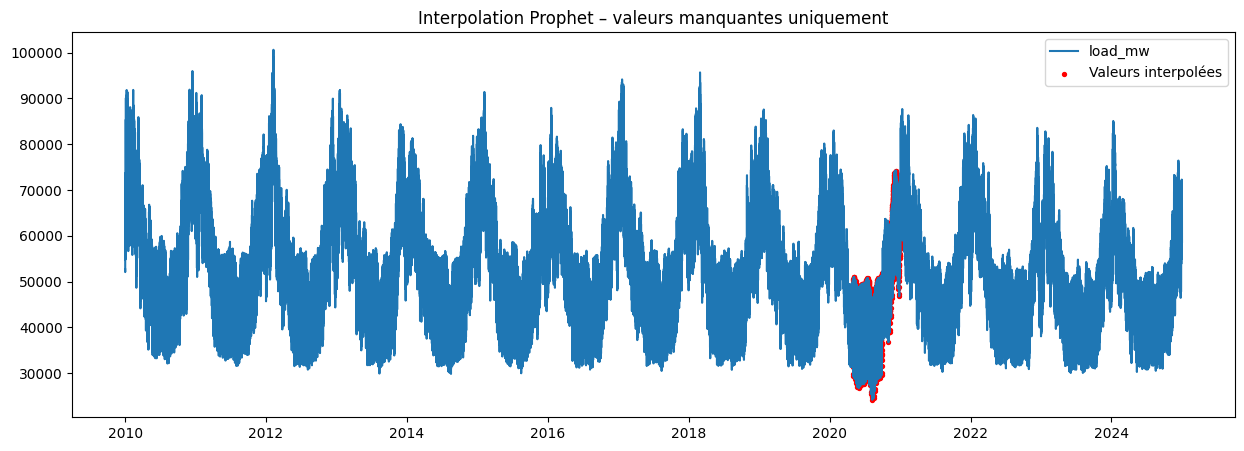

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(df_filled['datetime'], df_filled['load_mw'], label='load_mw')
plt.scatter(
    df.loc[df['load_mw'].isna(), 'datetime'],
    df_filled.loc[df['load_mw'].isna(), 'load_mw'],
    color='red',
    s=8,
    label='Valeurs interpolées'
)
plt.legend()
plt.title("Interpolation Prophet – valeurs manquantes uniquement")
plt.show()


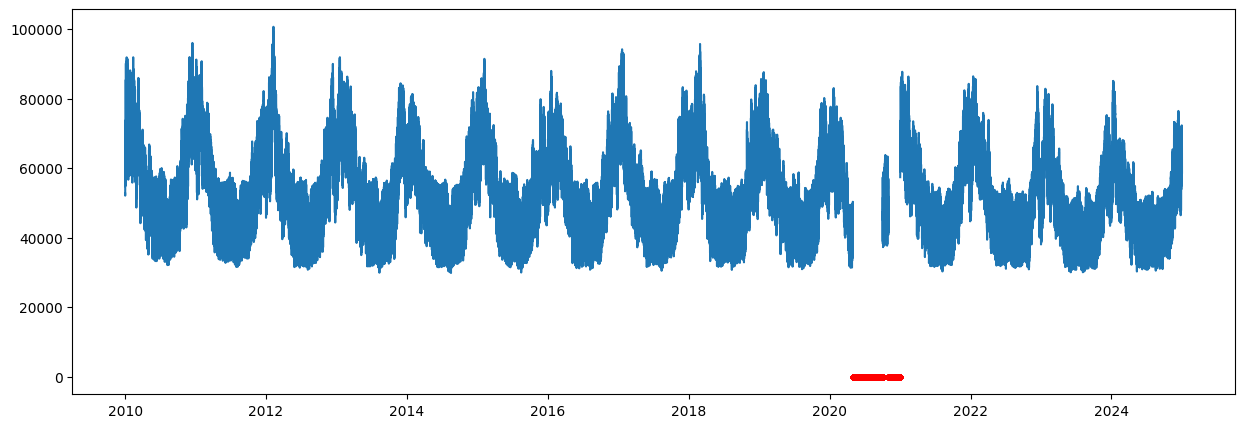

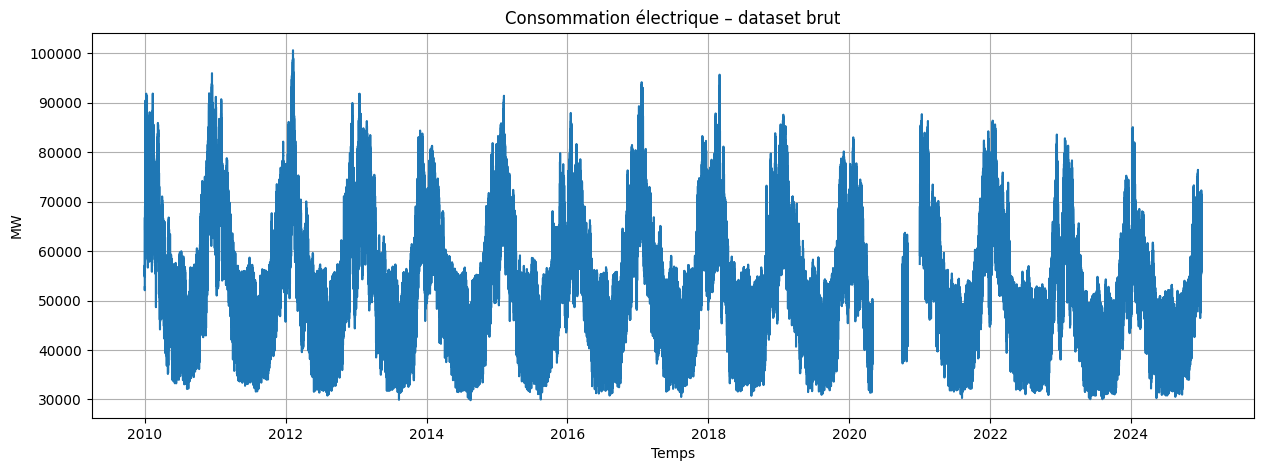

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

# Courbe principale (les NaN sont automatiquement ignorés)
plt.plot(df['datetime'], df['load_mw'], label='load_mw')

# Mettre en évidence les valeurs manquantes
mask = df['load_mw'].isna()
plt.scatter(
    df.loc[mask, 'datetime'],
    [0]*mask.sum(),   # juste pour les rendre visibles
    color='red',
    s=10,
    label='Valeurs manquantes'
)
plt.figure(figsize=(15,5))
plt.plot(df['datetime'], df['load_mw'])
plt.title("Consommation électrique – dataset brut")
plt.xlabel("Temps")
plt.ylabel("MW")
plt.grid(True)
plt.show()
